# Gradient Boosting for Feature Elimination

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


##### Set the Display size

In [2]:
rcParams['figure.figsize'] = 15, 10

##### Get the stored variables from other notebooks

In [3]:
%store -r data
%store -r col_year_month
%store -r col_categorical
%store -r col_target
%store -r col_numeric
%store -r combined_list

## Use some raw data to get a first look

#### Combine `col_numeric` and `col_target` to get a datset this modelling can work with

In [4]:
pre_combine_00 = [col_numeric, col_target]
combined_list_for_xgboost = [item for sublist in pre_combine_00 for item in sublist]
# combined_list_for_xgboost

In [5]:
len(data[combined_list_for_xgboost].columns)

15

### `data[combined_list_for_xgboost]` is our clean dataset, since it contains only numeric data and the target

In [7]:
data[combined_list_for_xgboost].head()

,arr_flights,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,target
0,11956.0,507.33,39.83,452.65,4.72,529.47,201.0,9.0,106950.0,50027.0,2842.0,13913.0,167.0,40001.0,1
1,588.0,34.71,4.71,19.77,0.32,38.49,13.0,2.0,5170.0,1754.0,312.0,655.0,16.0,2433.0,1
2,607.0,35.52,5.40,23.55,0.00,27.52,12.0,2.0,4485.0,1857.0,198.0,715.0,0.0,1715.0,1
3,1595.0,117.00,10.26,117.66,0.83,89.25,137.0,6.0,23698.0,9681.0,1592.0,4371.0,18.0,8036.0,1
4,327.0,23.67,1.47,14.50,0.06,19.29,0.0,0.0,2276.0,985.0,94.0,373.0,5.0,819.0,1


# Gradient Boosting

## `modelfit()`
without dummies
- 14 predictors

##### Adjust the variables

In [8]:
train = data[combined_list_for_xgboost]
target = 'target'
IDcol = 'ID'

##### Function defines XGBoost parameters - I

In [9]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['target'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='barh',color='red')
        plt.title ('Feature Ranks - no dummies')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9975
AUC Score (Train): 0.999975
CV Score : Mean - 0.9994707 | Std - 0.0001631409 | Min - 0.9992015 | Max - 0.9996357


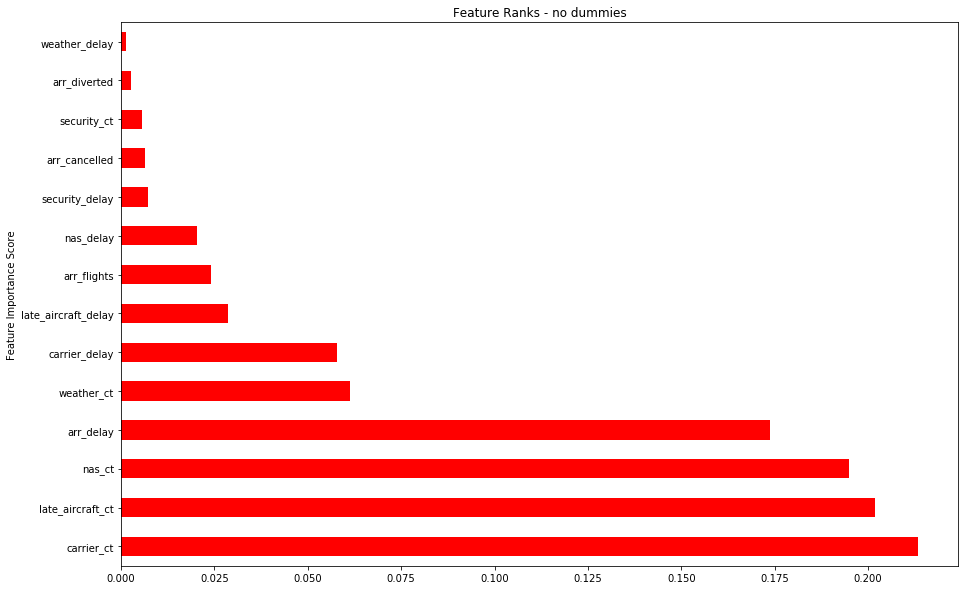

In [10]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [11]:
# get the list of features
print(predictors)

['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']


## Now let's try this on the dataset that has all the dummies

#### Retrieve the stored variable `data_for_models`

In [12]:
%store -r data_for_models

#### Remove the `year` column so it won't affect the model

In [13]:
# run this only once or it throws an error
data_for_models = data_for_models.drop('year', axis=1)
data_for_models.head()

,arr_flights,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,...,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11
0,11956.0,507.33,39.83,452.65,4.72,529.47,201.0,9.0,106950.0,50027.0,...,0,0,0,0,0,0,0,0,0,0
1,588.0,34.71,4.71,19.77,0.32,38.49,13.0,2.0,5170.0,1754.0,...,0,0,0,0,0,0,0,0,0,0
2,607.0,35.52,5.40,23.55,0.00,27.52,12.0,2.0,4485.0,1857.0,...,0,0,0,0,0,0,0,0,0,0
3,1595.0,117.00,10.26,117.66,0.83,89.25,137.0,6.0,23698.0,9681.0,...,0,0,0,0,0,0,0,0,0,0
4,327.0,23.67,1.47,14.50,0.06,19.29,0.0,0.0,2276.0,985.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
len(data_for_models.columns)

345

Adjust the variables

In [15]:
train2 = data_for_models
target2 = 'target'
IDcol2 = 'ID'

## `modelfit2()`
__with__ dummies
- 345 predictors

this is different from modelfit() in that 
- it uses `.nlargest(len(train2.columns)//10)` to limit the plotted features to 10% of the results... without this limitation, we get the rank of __almost__ __350__ columns in a barplot, and it becomes a jumble to look at... (see below)
- it is arranged from most important to least
- it is colored green

In [16]:
feature_catcher_xx = []

##### Function defines XGBoost parameters - II

In [17]:
def modelfit2(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain.target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain.target, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain.target.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain.target, dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feature_catcher_xx.append(feat_imp)
        feat_imp.nlargest(len(train2.columns)//10).plot(kind='barh', color='green')
        plt.title('Feature Rank - Include Dummies', size=45)
        plt.ylabel('Feature Importance Score', size=30 )
        

Adjust the Display Size, since there are many features... 

In [18]:
rcParams['figure.figsize'] = 40,20


Model Report
Accuracy : 0.998
AUC Score (Train): 0.999978
CV Score : Mean - 0.9994289 | Std - 0.0001499955 | Min - 0.9992124 | Max - 0.9996124


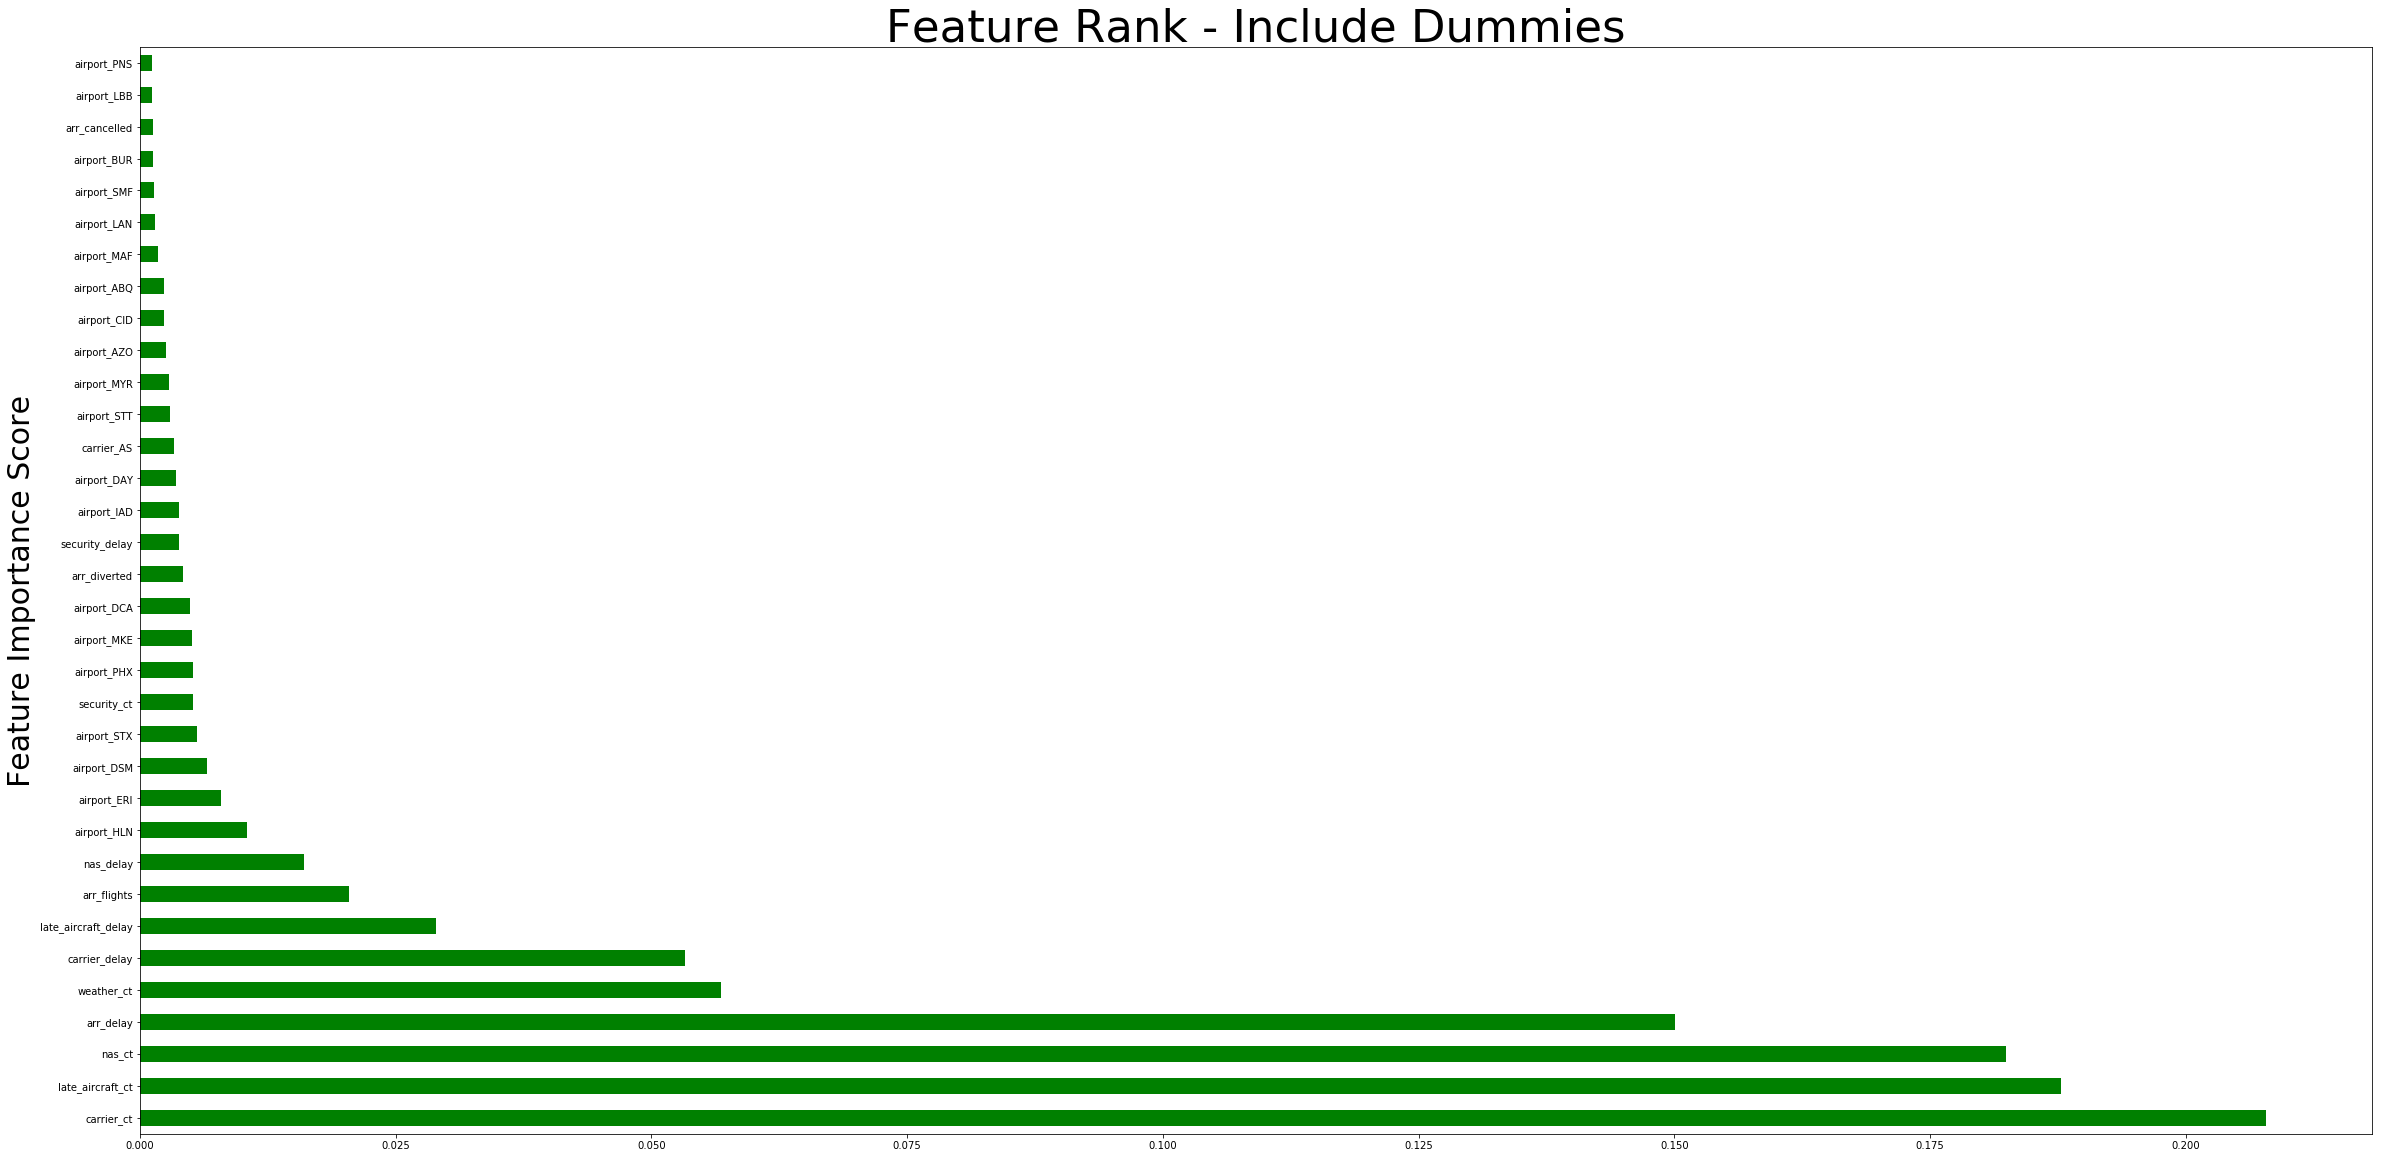

In [19]:
#Choose all predictors except target & IDcols
predictors2 = [x for x in train2.columns if x not in [target2, IDcol2]]
gbm2 = GradientBoostingClassifier(random_state=10)
modelfit2(gbm2, train2, predictors2)

#### Some commented out code to inspect the output

In [20]:
# get the list of features
# print(predictors2)

In [21]:
# feature_catcher_xx

get the predictive features that are not airports

In [22]:
pred_feats = ['carrier_ct', 'late_aircraft_ct', 'nas_ct', 'arr_delay', 'weather_ct', 
              'carrier_delay', 'late_aircraft_delay', 'arr_flights', 'nas_delay']

Now let's get the airports that show up on this list

In [23]:
# this cell 
predictive_airports = ['HLN','ERI','DSM','STX','PHX','MKE','DCA','IAD','DAY','STT','MYR','AZO','CID','ABQ','MAF','LAN','SMF','BUR','LBB','PNS']
%store predictive_airports

Stored 'predictive_airports' (list)


## Jumbled - too many features

In [24]:
train3 = data_for_models
target3 = 'target'
IDcol3 = 'ID'

In [25]:
feature_catcher_3_xx = []

In [26]:
def modelfit3(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain.target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain.target, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain.target.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain.target, dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feature_catcher_3_xx.append(feat_imp)
        feat_imp.plot(kind='barh', color='darkblue')
        plt.title('Feature Rank Before Filter - Include Dummies \nIts a Jumble ', size=45)
        plt.ylabel('Feature Importance Score')

Adjust the Display Size, since there are many features... 

In [27]:
rcParams['figure.figsize'] = 40,20


Model Report
Accuracy : 0.998
AUC Score (Train): 0.999978
CV Score : Mean - 0.9994289 | Std - 0.0001499955 | Min - 0.9992124 | Max - 0.9996124


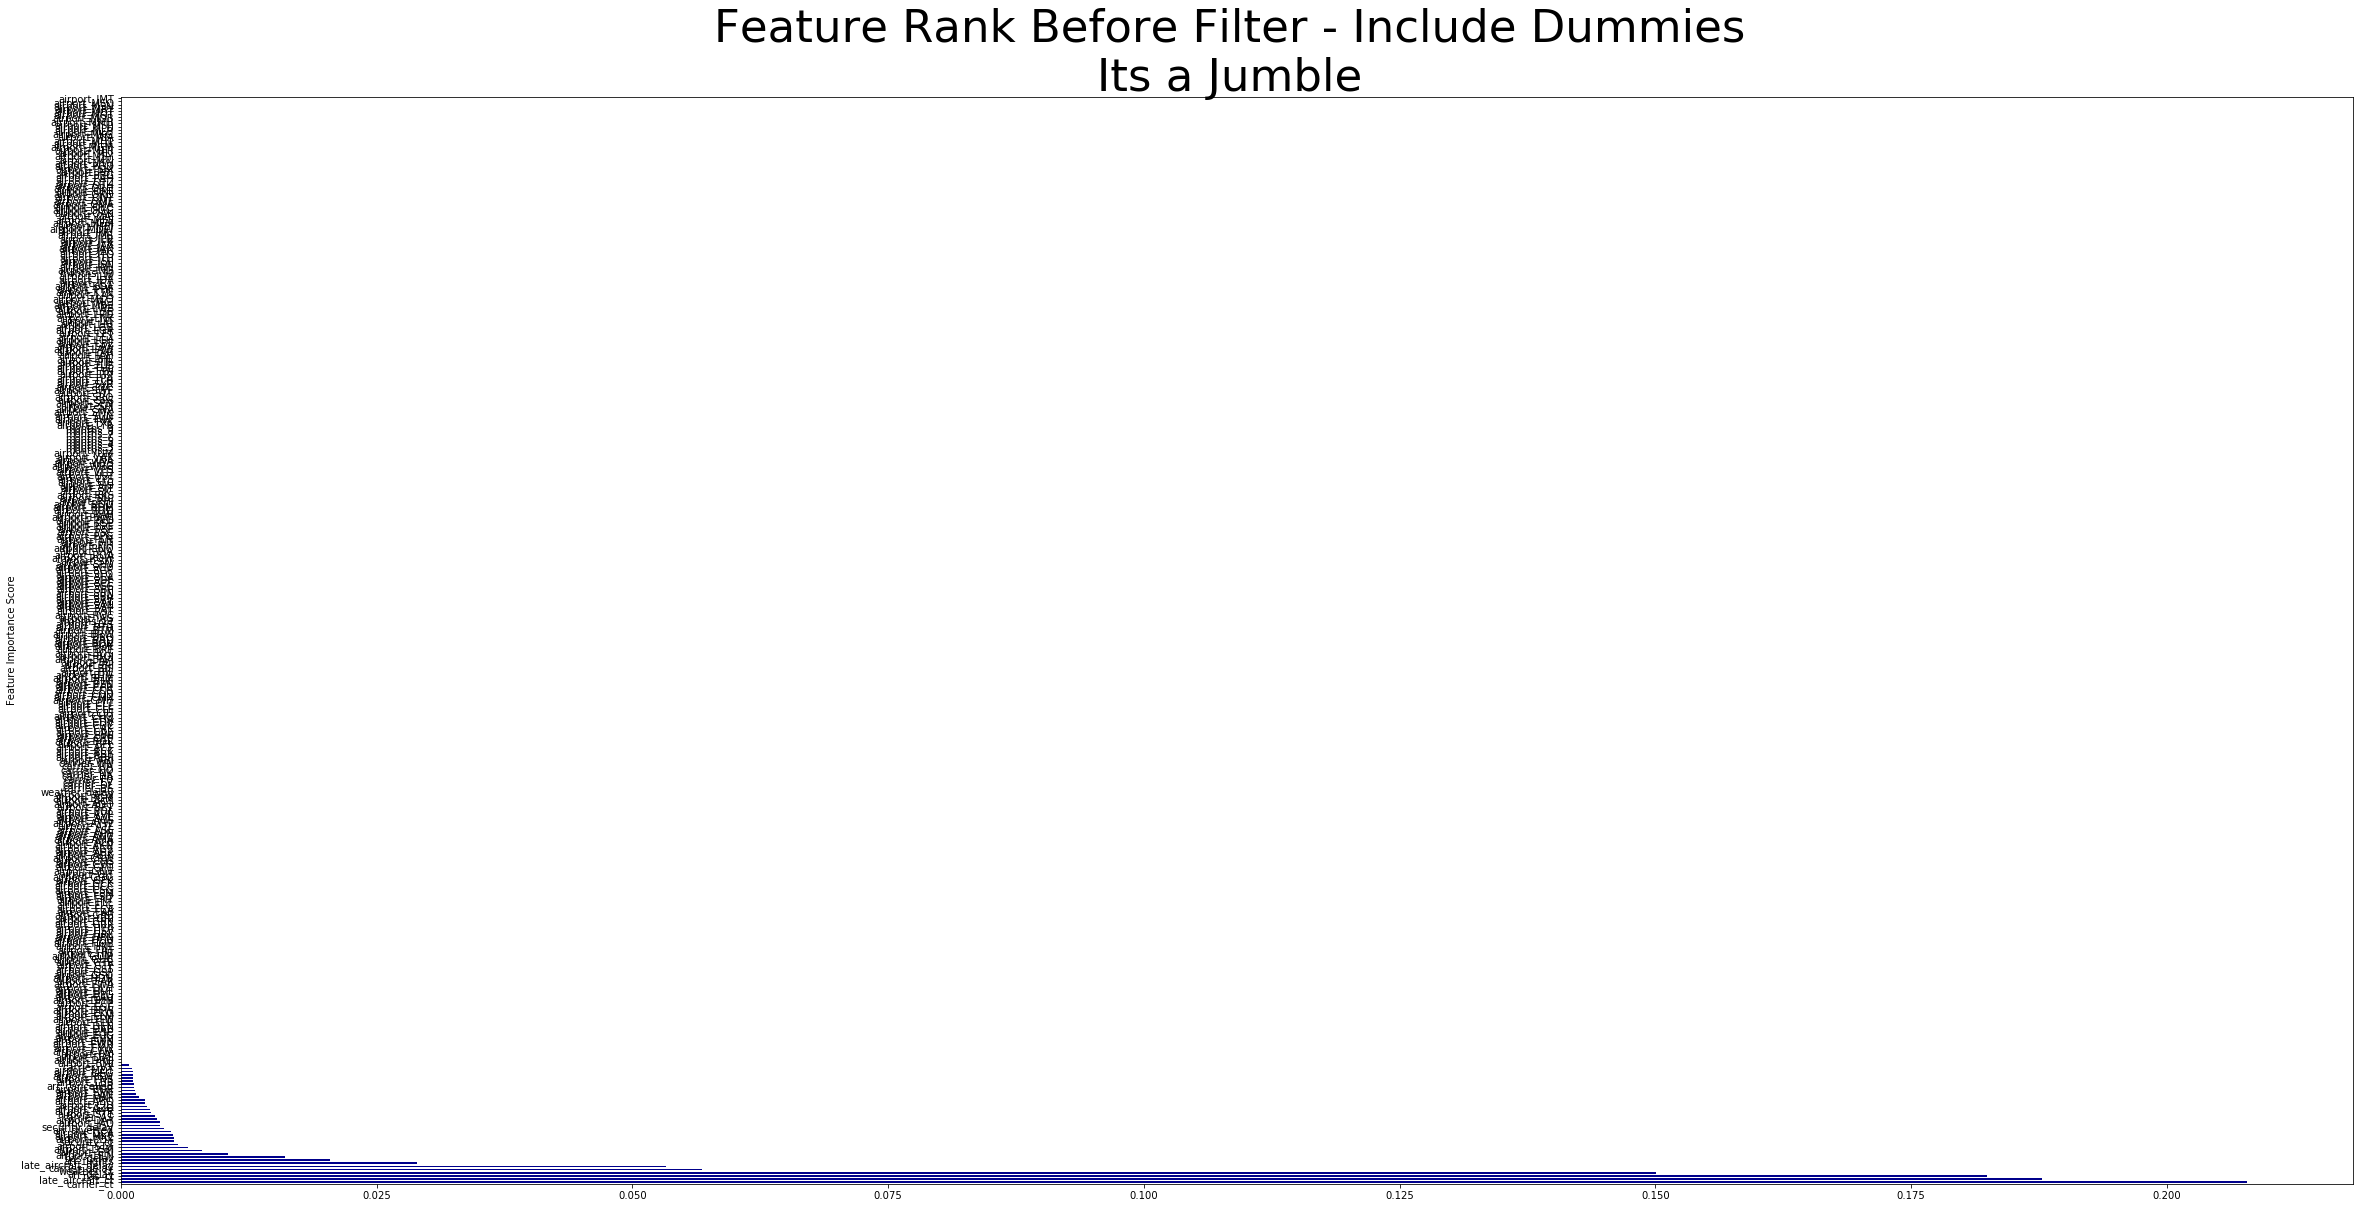

In [28]:
# this takes about 60 seconds to run
# and it depends on the function line xx or so...
# `
# feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False).nlargest(len(train2.columns)//10)
# '
# shortened to:
# '
# feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
# '
# '
#  
#Choose all predictors except target & IDcols
predictors3 = [x for x in train3.columns if x not in [target3, IDcol3]]
gbm3 = GradientBoostingClassifier(random_state=10)
modelfit3(gbm3, train3, predictors3)

#### Some commented out code to inspect the features

In [29]:
# get the list of features
# print(predictors3)

In [30]:
# feature_catcher_3_xx